# <center>Facebook Mutual Friends Analysis</center>

## Introduction
In this fun mini-project, with the Python module NetworkX, we will be exploring a Facebook friend list of a user. There are two ways to gather the required data. First, Facebook provides fantastic [API](https://developers.facebook.com/tools/explorer/) tools that are easy to utilize. Unfortunately, recent policy changes have made the Graph API explorer rather useless, as it can't return any information about Facebook friends that haven't enabled the graph explorer app. This change is very unfortunate since users can't even access information that is publicly available when logged in. The second option is to web-scrape the data. I spend some time developing a scraper that would read the information I desired, but it came to my attention that this is against the ToS provided by Facebook. Thus, there is no proper way to collect a complete list of your friends and mutual friends (per friend) without breaking the rules. As such, for this project we will be using data collected by [SNAP](https://snap.stanford.edu/data/egonets-Facebook.html) (Stanford Network Analysis Project). For linguistic ease, I will assume that this is my personal friend list.

Each node in the graph represents a user that is on my friends list, and nodes that have edges between them are Facebook friends. Note that I don't have a node for myself, but since this graph is my friend list, my node would simply be connected to every other node. Also, the network is self-contained, meaning there aren't edges that go to users outside of my friend list.

## Basic Information

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('bmh')

First, let's count the rows in the *feat* file, showing how many friends I have on my friend list.

In [2]:
with open('1684.feat') as f:
        for i, l in enumerate(f):
            pass
print('Total of ' + str(i+1) + ' friends.')        

Total of 792 friends.


We first initialize the graph wwith the edges from the *edges* file.

In [3]:
G = nx.read_edgelist('1684.edges', nodetype=int, create_using=nx.Graph())

In [4]:
#Print basic summary
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 786
Number of edges: 14024
Average degree:  35.6845


The first thing to notice is that the graph has 786 nodes. This means that I have $792-786=6$ friends who share no mutual friends with me. It is not surprising that this number is so low; most of my friends are from some friend circle, i.e., school, work, family, hobbies, so it would be rare to not share any friends in common with them.

From here on, we will exclude these 6 friends from the graph and discussion. An additional interesting fact is that on average, I have 35 mutual friends with any of my friends.


## Visuals
Let's take a peak at how the graph looks. We will be using a [force-directed graph drawing](https://en.wikipedia.org/wiki/Force-directed_graph_drawing) (spring_layout in NetworkX).

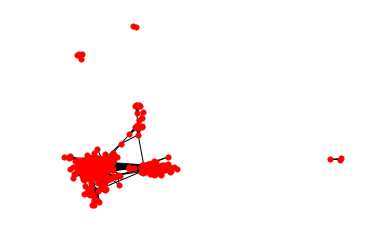

In [5]:
spring_pos = nx.spring_layout(G)
plt.axis('off')
nx.draw_spring(G, node_size=30)

We can begin to see some clusters. It appears that there are 4 connected components of nodes, 3 very small sets and 1 large set. Within the large set, there are most likely smaller communities. Let's take advantage of the community module, which implements the [Louvain method](https://en.wikipedia.org/wiki/Louvain_Modularity) for community detection. We won't be going deep into the theory of community detection, but there are plenty of high-quality [technical papers](http://i.stanford.edu/~julian/pdfs/nips2012.pdf) to peruse if interested.

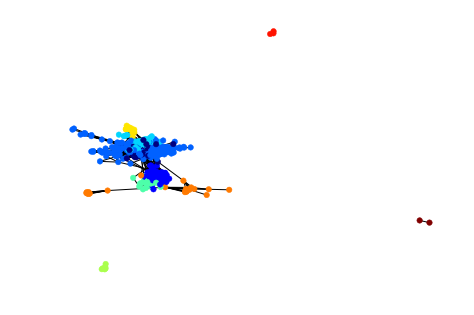

In [6]:
import community
louvain = community.best_partition(G)
partition = [louvain[n] for n in G.nodes()]
nx.draw_spring(G, node_size=30, cmap=plt.get_cmap('jet'), node_color=partition)

It seems like the Louvain method did a reasonable job at detecting communities. Later, we will get rid of the 3 small sets in order to focus on the larger set.

## Stats of Interest
For now, let's investigate a few more properties of the graph. Let's answer the question:

**What is the largest set of friends in which everyone is friends with everyone else?**

Note that in terms of graph theory, this corresponds to the largest clique.

In [7]:
from networkx.algorithms.approximation import clique
max_c = clique.max_clique(G)
len(max_c)

26

This maximally sized clique probably corresponds to a club or a team that interacts frequently via a Facebook group.

Let's find the **largest number of mutual friends** that I share with any one person.

In [8]:
degrees = list(G.degree())
degree_dict = {n:d for n, d in degrees if d!=0}
max_friends = max(degree_dict.values())
print(max_friends)

136


Wow, one of my friends is also friends with 136 of my other friends! There seem to be two main possibilities. The first is that this friend is my significant-other and would thus share a lot of Facebook friends with me. The second is that this particular friend spans multiple communities. For example, maybe this friend is part of my family, attended the same high-school and college, and was on the same soccer team as I was.

Let's plot the distribution of mutual friends, both in a histogram and empirical CDF plot.

Text(0.5,0,'Number of Mutual Friends')

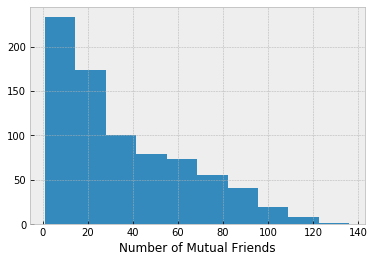

In [9]:
plt.hist(degree_dict.values())
plt.xlabel('Number of Mutual Friends')

Text(0,0.5,'CDF')

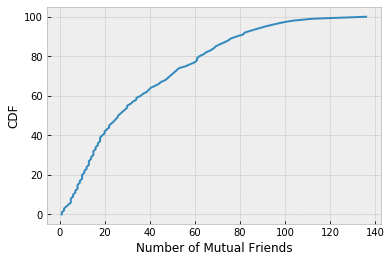

In [10]:
import numpy as np
y = np.arange(0,101)
z = np.array(list(degree_dict.values()))
x = np.percentile(z,y)
plt.plot(x,y)
plt.xlabel('Number of Mutual Friends')
plt.ylabel('CDF')

We see that around half of my friends have 25 or fewer mutual friends, while less than 3% of my friends have more than 100 friends in common.

## Focus on Largest Set
Let's now get rid of the 3 small connected components.

In [11]:
graphs = list(nx.connected_component_subgraphs(G))
for graph in graphs:
    print(len(graph.nodes()))

775
6
3
2


We finally have confirmation that there are 4 connected component sets, one major one. Let's take a closer look at the large one.

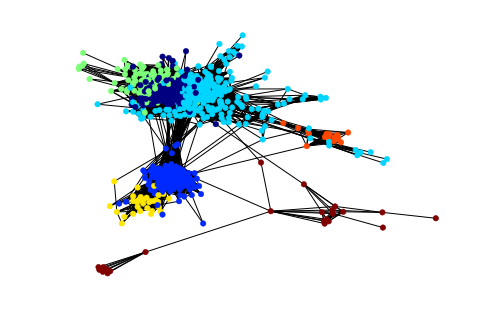

In [12]:
G_sub = graphs[0]
louvain = community.best_partition(G_sub)
partition = [louvain[n] for n in G_sub.nodes()]
nx.draw_spring(G_sub, node_size=30, cmap=plt.get_cmap('jet'), node_color=partition)

In [13]:
print(max(louvain.values())-min(louvain.values())+1)

7


The Louvain method split the group into 7 communities. Let's now answer the following question:

**What is the smallest number of my friends such that their mutual friends cover all of my friends?**

(Keep in mind, from here on out we are only focused on the set at hand, not the small connected component sets we eliminated earlier.) In graph theoretic terms, the answer to this question is known as the [minimum weight dominating set](https://en.wikipedia.org/wiki/Dominating_set).

In [14]:
from networkx.algorithms.approximation import dominating_set
min_set = len(dominating_set.min_weighted_dominating_set(G_sub))
print(min_set)

566


The result indicates that it requires connections from 566 friends for all 775 of my friends to be included.

We now focus on [degrees of separation](https://en.wikipedia.org/wiki/Six_degrees_of_separation). If you know somebody directly, then you two are 1 degree apart. If somebody is a friend of a friend, but you don't know them personally, then you are separated by 2 degrees, and so on. This notion became popular with the [Six Degrees of Kevin Bacon](https://en.wikipedia.org/wiki/Six_Degrees_of_Kevin_Bacon) notion, stating that actors can trace their acting credits to Kevin Bacon in 6-or-fewer jumps (see [The Oracle of Bacon for a computer search through IMDB solving for any actor](https://oracleofbacon.org/)). There is an analogous notion in math academia--[The Erdős Number](https://en.wikipedia.org/wiki/Erd%C5%91s_number), i.e., how many coauthor publication jumps to famous mathematician Paul Erdős.

In our graph, the maximum degrees of separation for any of my friends is 2, because they both have me as a friend. But let's pretend I didn't exist and **find the maximum degrees of separation between any two of my friends.**

In [15]:
shortest = nx.all_pairs_shortest_path_length(G_sub)

In [16]:
type(shortest)

generator

In [17]:
dist_each = dict(nx.all_pairs_shortest_path_length(G_sub))

In [18]:
max_dist = [max(v.values()) for k,v in dist_each.items()]

Text(0.5,0,'Maximum Shortest Path to Another Node')

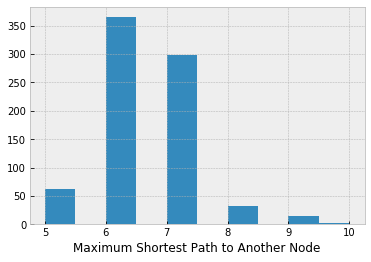

In [19]:
plt.hist(max_dist)
plt.xlabel('Maximum Shortest Path to Another Node')

In [20]:
max(max_dist)

10

The maximum degrees of separation between any two of my friends is 10 (assuming I didn't exist). The most common maximum degrees of separation are 6 and 7.

Lastly, I would like to answer the following question:

**What is the largest set of my friends such that no two people in the set are friends?**

Another way to put it is what is the largest number of my friends that I could invite to a party in which they would all be strangers to everyone else (assuming a pair would be Facebook friends if they were not strangers). In graph theory, this is equivalent to the maximum [independent set](https://en.wikipedia.org/wiki/Independent_set_(graph_theory)), i.e., the largest collection of nodes that share no edges.

In [21]:
from networkx.algorithms.approximation import independent_set
max_ind_set = independent_set.maximum_independent_set(G_sub)
print(len(max_ind_set))

134


Wow! Even though my friends can be divided roughly into 7 communities, I can assemble a set of 134 of my friends in which no one is friends with anyone else.